In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pylab as plt
import zipfile
import os
import cv2
import torchvision
from torchvision import datasets, models, transforms
import time
from torchvision.models import inception_v3
from sklearn.metrics import classification_report,confusion_matrix
from torch.utils.data import DataLoader, random_split
from sklearn.manifold import TSNE
import sklearn.metrics as metrics
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = 'drive/My Drive/Datasets'

with zipfile.ZipFile(zip_file_path + '/Dataset_3.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Mounted at /content/drive


In [ ]:
# Define path to your dataset folder
dataset_dir = '/content/Dataset_3'

# Create a dataset instance
dataset = datasets.ImageFolder(root=dataset_dir)

# Define the sizes of train, validation sets
train_size = int(0.7 * len(dataset))   # 70% of the dataset for training
val_size = int(0.1 * len(dataset))   # Remaining 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 20% for testing

# Split the dataset into train, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to match Inception input size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply transformations to train and test datasets
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform

# Create DataLoader for batching and shuffling data
train_batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Create DataLoader for batching and shuffling data
valid_batch_size = 32
valid_data_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)
test_batch_size = 32
test_data_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

14796
2113
4229


In [ ]:
# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(dataset.classes)
print(num_classes)
print(dataset.classes)

# Define the Inception model
model = models.inception_v3(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)


28
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Chili__healthy', 'Chili__leaf curl', 'Chili__leaf spot', 'Chili__whitefly', 'Chili__yellowish', 'Coffee__Rust', 'Coffee__healthy', 'Coffee__red spider mite', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [ ]:
# Define the Inception model
model = models.inception_v3(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Train the model
num_epochs = 15
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_data_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in valid_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    valid_loss = running_loss / len(valid_data_loader)
    valid_acc = correct_test / total_test
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_acc:.4f}")


Epoch [1/15], Train Loss: 1.0789, Train Acc: 0.6712, Validation Loss: 0.4981, Validation Acc: 0.8367
Epoch [2/15], Train Loss: 0.4383, Train Acc: 0.8503, Validation Loss: 0.3286, Validation Acc: 0.8864
Epoch [3/15], Train Loss: 0.3202, Train Acc: 0.8935, Validation Loss: 0.2947, Validation Acc: 0.9068
Epoch [4/15], Train Loss: 0.2650, Train Acc: 0.9104, Validation Loss: 0.3121, Validation Acc: 0.9077
Epoch [5/15], Train Loss: 0.2356, Train Acc: 0.9186, Validation Loss: 0.2897, Validation Acc: 0.9124
Epoch [6/15], Train Loss: 0.2071, Train Acc: 0.9300, Validation Loss: 0.2166, Validation Acc: 0.9361
Epoch [7/15], Train Loss: 0.1829, Train Acc: 0.9378, Validation Loss: 0.2105, Validation Acc: 0.9323
Epoch [8/15], Train Loss: 0.1799, Train Acc: 0.9405, Validation Loss: 0.1705, Validation Acc: 0.9423
Epoch [9/15], Train Loss: 0.1554, Train Acc: 0.9487, Validation Loss: 0.1699, Validation Acc: 0.9427
Epoch [10/15], Train Loss: 0.1384, Train Acc: 0.9534, Validation Loss: 0.2135, Validation A

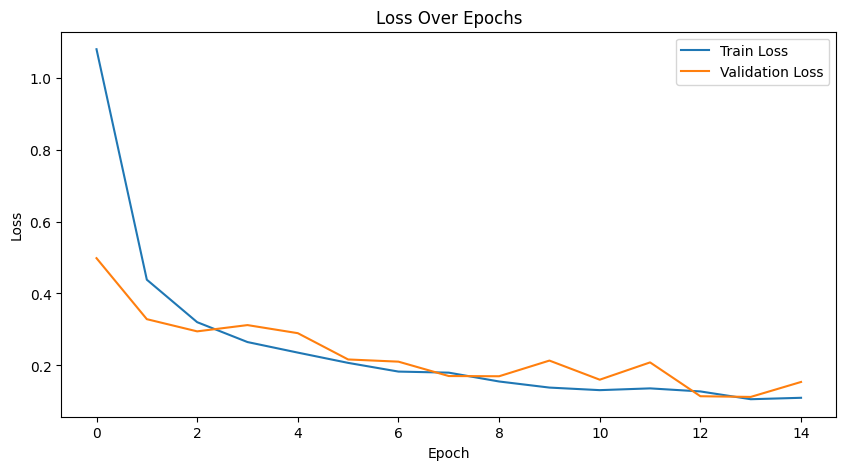

In [ ]:
# Generate predictions
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in valid_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot loss
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

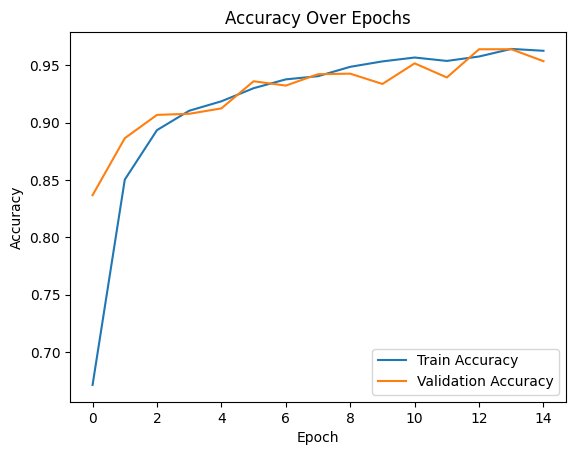

In [ ]:
# Plot Accuracy
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Generate classification report
class_report = classification_report(all_labels, all_preds)
print(class_report)
# Generate classification matrix
class_matrix = confusion_matrix(all_labels, all_preds)
print(class_matrix)

              precision    recall  f1-score   support

           0       1.00      0.75      0.85        55
           1       0.97      0.97      0.97        70
           2       0.91      0.97      0.94        33
           3       0.91      0.99      0.95       168
           4       0.95      1.00      0.98       119
           5       0.95      0.93      0.94        80
           6       0.75      0.67      0.71         9
           7       0.23      0.60      0.33         5
           8       0.67      0.40      0.50         5
           9       0.86      0.35      0.50        17
          10       0.60      0.75      0.67         4
          11       0.64      0.97      0.78        39
          12       0.97      0.84      0.90        44
          13       0.67      0.12      0.20        17
          14       0.95      0.95      0.95        58
          15       1.00      1.00      1.00       113
          16       0.97      0.96      0.96        99
          17       0.95    

In [ ]:

# Generate predictions on test data
all_preds_test = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())
accuracy = metrics.accuracy_score(all_labels_test, all_preds_test)
print("Accuracy:", accuracy)

Accuracy: 0.9508157956963821


In [ ]:
# Generate classification report of test dataset
class_report_test = classification_report(all_labels_test, all_preds_test)
print(class_report_test)
# Generate classification matrix of test dataset
class_matrix_test = confusion_matrix(all_labels, all_preds)
print(class_matrix_test)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       138
           1       0.97      0.98      0.98       130
           2       0.87      0.98      0.92        56
           3       0.89      0.99      0.94       295
           4       0.96      0.99      0.98       212
           5       0.97      0.95      0.96       157
           6       0.81      0.76      0.79        17
           7       0.47      0.70      0.56        10
           8       0.54      0.33      0.41        21
           9       0.80      0.40      0.53        10
          10       0.68      0.62      0.65        21
          11       0.62      0.92      0.74        91
          12       0.93      0.89      0.91        88
          13       0.57      0.10      0.17        40
          14       0.86      0.93      0.89        96
          15       1.00      0.99      0.99       241
          16       0.95      0.91      0.93       183
          17       0.97    

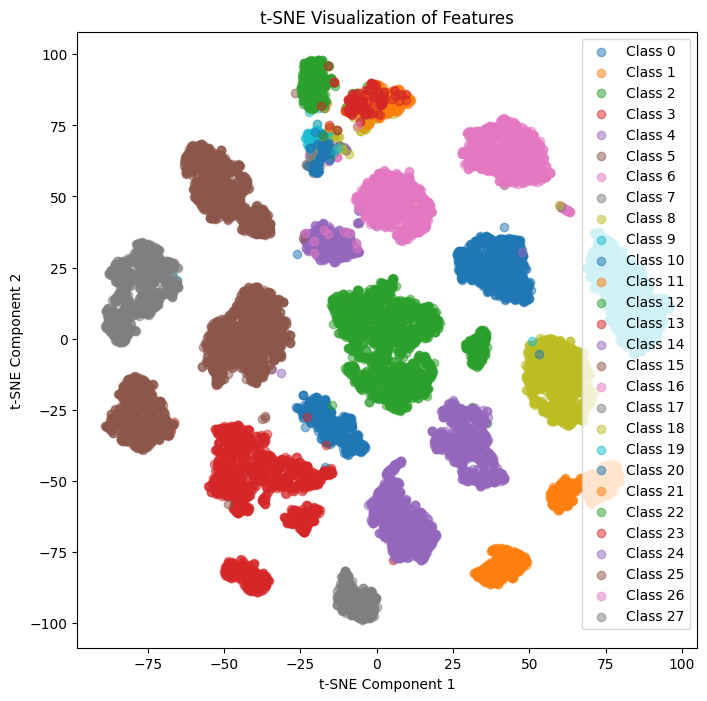

In [ ]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_test) == class_idx, 0],
                embedded_features[np.array(all_labels_test) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

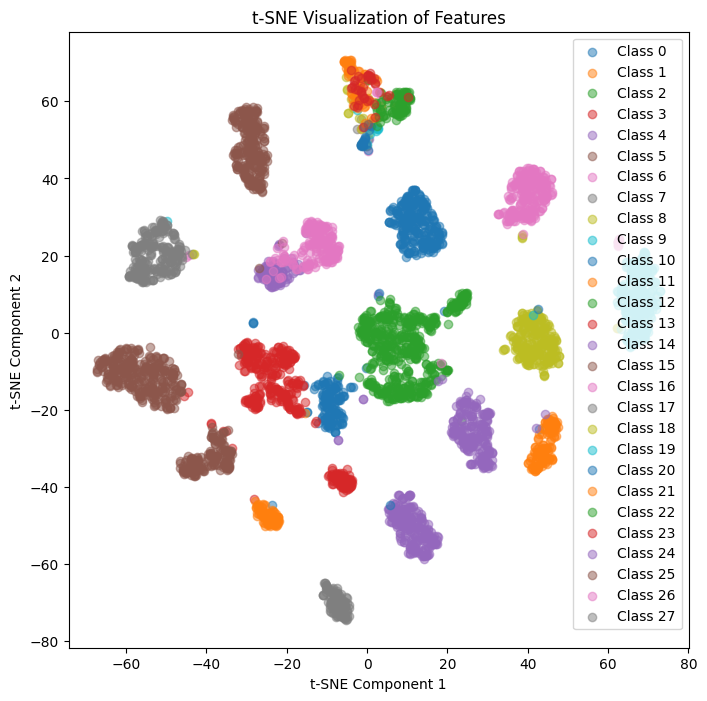

In [ ]:
# Get features from the penultimate layer of the Inception model
features = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        features.extend(outputs.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

features = np.array(features)
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(num_classes):
    plt.scatter(embedded_features[np.array(all_labels_test) == class_idx, 0],
                embedded_features[np.array(all_labels_test) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()